In [ ]:
# !pip install joypy

Here we have divided the data to find if there are differences in the
* Phase1 : Early(<25 days) in Space vs
* Phase2 : Overtime(>25 days) and
* Phase3 : Post-Return to Earth

Grouped by their **RadioSensitivity Levels**:
* Highly Radiosensitive Tissues (Eyes, Skin, Thymus, Spleen)
* Intermediate Radiosensitivity Tissues (Liver, Kidney, Heart, Lung, Adrenal Glands)
* Low Radiosensitive Tissues (Muscle and Brain)

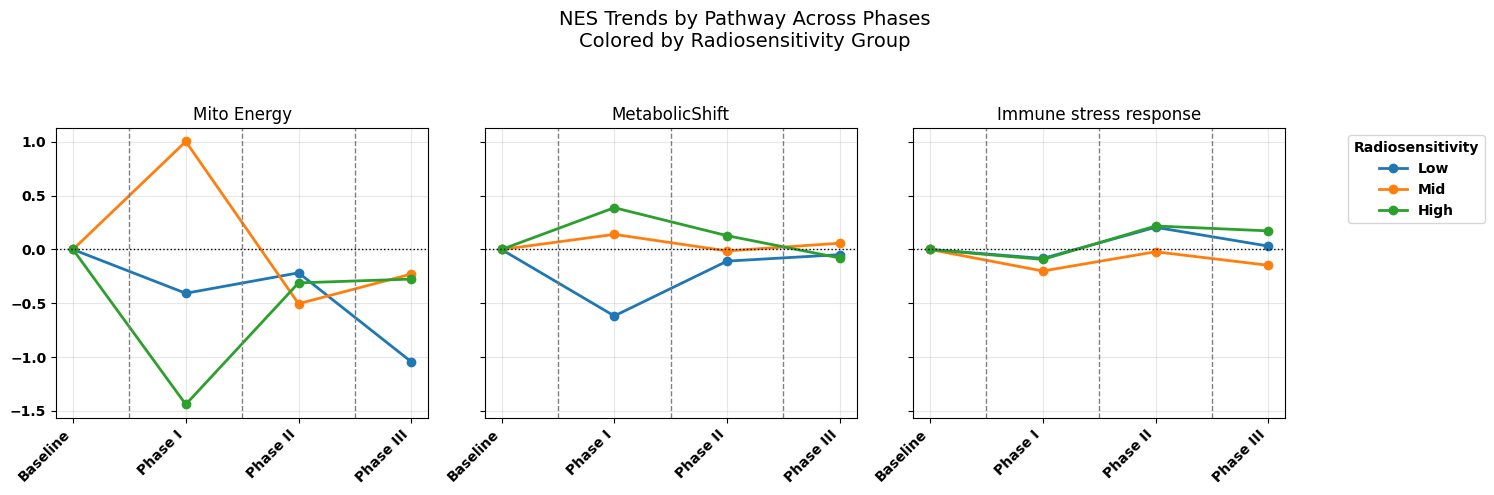

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
df = pd.read_excel('All_strain.xlsx')

# Define the three pathway groups by column index
group1_cols = df.columns[9:21]    # Mitochondria complexes & proteins
group2_cols = df.columns[22:38]   # Metabolic shift markers
group3_cols = df.columns[38:]     # Immune & stress response markers

# Compute per-sample NES averages
df['Mito_Energy'] = df[group1_cols].mean(axis=1)
df['MetabolicShift'] = df[group2_cols].mean(axis=1)
df['Immune_stress_response'] = df[group3_cols].mean(axis=1)

# Create RadiosensitivityGroup
def map_rad(x):
    if x in [5, 4]:
        return 'Low'
    if x == 3:
        return 'Mid'
    if x in [2, 1]:
        return 'High'
    return 'Unknown'
df['RadiosensitivityGroup'] = df['Radio_Sensitivity'].apply(map_rad)

# Create MissionPhase including baseline
def mission_phase(row):
    if row['Return_Days'] == 0 and row['ISS_Days'] < 25:
        return 'Phase I: Adaptive Response'
    if row['Return_Days'] == 0 and row['ISS_Days'] >= 25:
        return 'Phase II: Systemic Failure'
    if row['Return_Days'] > 0:
        return 'Phase III: Lingering Aftermath'
    return 'Phase 0: Baseline'
df['MissionPhase'] = df.apply(mission_phase, axis=1)

# Prepare “status” column
df['Status'] = np.where(df.Return_Days==0, 'In-Flight', 'Post-Landing')

# Calculate Overall_NES
df['Overall_NES'] = df[['Mito_Energy', 'MetabolicShift', 'Immune_stress_response']].mean(axis=1)

# Common color map
status_order = ['In-Flight','Post-Landing']

# Prepare a small DataFrame
rd = df[df.Status.isin(['In-Flight','Post-Landing'])][['Overall_NES','Status']]

# Define orders and colors
RS_groups = ['Low', 'Mid', 'High']
phases_all = ['Phase 0: Baseline', 'Phase I: Adaptive Response', 'Phase II: Systemic Failure', 'Phase III: Lingering Aftermath']
x_pos = range(len(phases_all))
pathways = ['Mito_Energy', 'MetabolicShift', 'Immune_stress_response']
colors = {'Low': 'tab:blue', 'Mid': 'tab:orange', 'High': 'tab:green'}

# Build figure with one panel per pathway
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

for ax, pw in zip(axes, pathways):
    for rs in RS_groups:
        means = []
        for ph in phases_all:
            if ph == 'Phase 0: Baseline':
                means.append(0)
            else:
                sub = df[(df['RadiosensitivityGroup'] == rs) & (df['MissionPhase'] == ph)]
                means.append(sub[pw].mean() if not sub.empty else 0)
        ax.plot(x_pos, means, marker='o', linewidth=2, label=rs, color=colors[rs])
    # Add separators between phases
    for sep in [0.5, 1.5, 2.5]:
        ax.axvline(sep, linestyle='--', color='gray', linewidth=1)
    # Baseline horizontal line
    ax.axhline(0, linestyle=':', color='black', linewidth=1)
    # Formatting
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['Baseline', 'Phase I', 'Phase II', 'Phase III'], rotation=45, ha='right')
    ax.set_title(pw.replace('_', ' '), fontsize=12)
    ax.grid(alpha=0.3)

# Legend
axes[-1].legend(title='Radiosensitivity', bbox_to_anchor=(1.15, 1), loc='upper left')

plt.suptitle('NES Trends by Pathway Across Phases\nColored by Radiosensitivity Group', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

plt.show()

**Distribution Plots** for **In-Flight vs Post-Flight** (also by) **Radio-Sensitive Groups**

/usr/local/lib/python3.11/dist-packages/joypy/joyplot.py:435: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  fig, axes = _subplots(naxes=num_axes, ax=ax, squeeze=False,


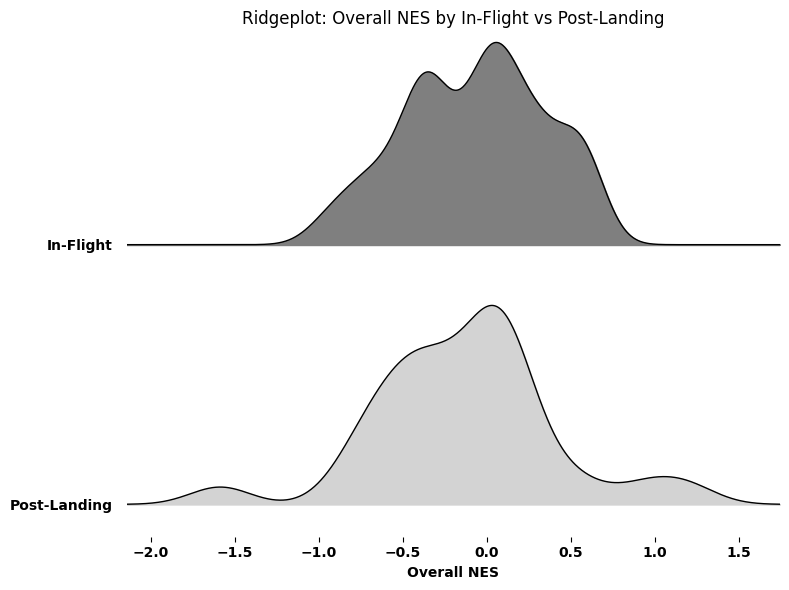

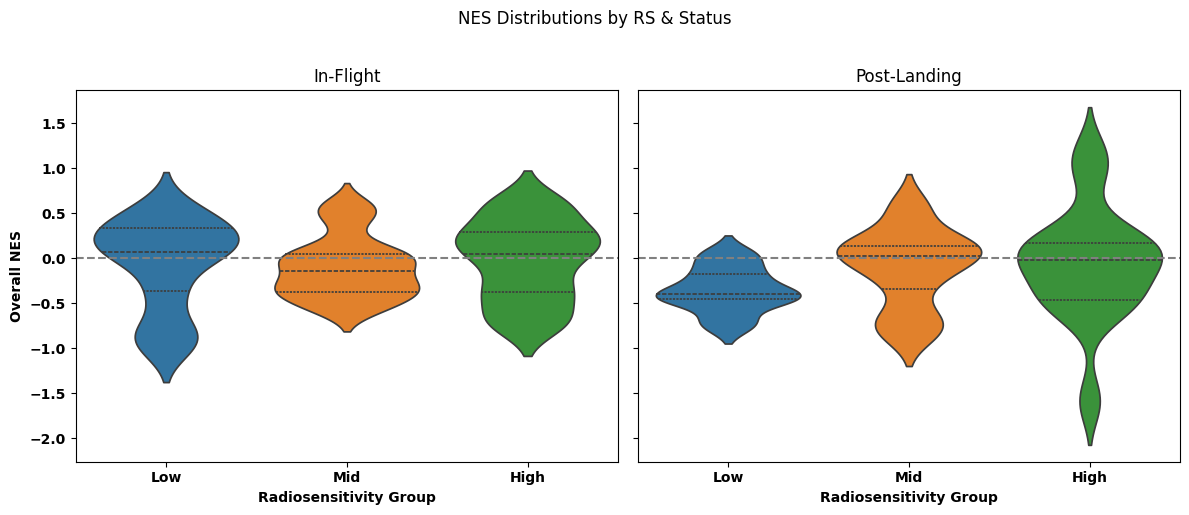

In [ ]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
import joypy

fig, ax = plt.subplots(figsize=(8,6))
joypy.joyplot(
    rd, by='Status', column='Overall_NES',
    color=['tab:grey','lightgrey'],
    linewidth=1, ax=ax, overlap=0.5
)
plt.title('Ridgeplot: Overall NES by In-Flight vs Post-Landing') # PF more Negative-tailed
plt.xlabel('Overall NES')
plt.tight_layout()
plt.show()

# Violin distributions by RS Group & Status -----------------------------
fig, axes = plt.subplots(1,2, figsize=(12,5), sharey=True)
for ax, status in zip(axes, status_order):
    sub = df[df.Status==status]
    sns.violinplot(x='RadiosensitivityGroup', y='Overall_NES', hue='RadiosensitivityGroup',
                   data=sub, order=RS_groups, palette=colors,
                   density_norm='width', inner='quartile', ax=ax, legend=False)
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_title(status)
    ax.set_xlabel('Radiosensitivity Group')
axes[0].set_ylabel('Overall NES')
plt.suptitle('NES Distributions by RS & Status', y=1.02)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.tight_layout()
plt.show()

**Linear Regression** for NES Scores by **Radio-Sensitive** Groups Over **Time** at the **(ISS)** International Space Station.

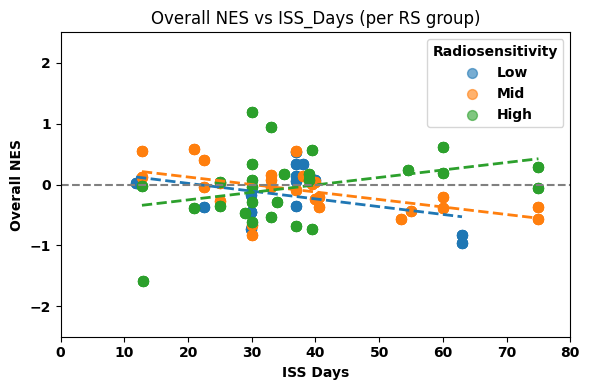

In [ ]:
# 1) Scatter + OLS by RS
plt.figure(figsize=(6,4))
for rs in RS_groups:
    sub = df[df.RadiosensitivityGroup==rs]
    X = sub[['ISS_Days']].values
    y = sub['Overall_NES'].values
    plt.scatter(X, y, label=rs, color=colors[rs], alpha=0.6, s=50)
    if len(X) > 1:
        lm = LinearRegression().fit(X, y)
        xs = np.linspace(X.min(), X.max(), 100)[:,None]
        plt.plot(xs, lm.predict(xs), color=colors[rs], linestyle='--', linewidth=2)
plt.axhline(0, color='gray', linestyle='--')
plt.xlim(0, df.ISS_Days.max()+5)
plt.ylim(-2.5, 2.5)
plt.xlabel('ISS Days')
plt.ylabel('Overall NES')
plt.title('Overall NES vs ISS_Days (per RS group)')
plt.legend(title='Radiosensitivity')
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.tight_layout()
plt.show()


**Faceted** by **Status** In-Flight Or On-Earth: Assumption to find similar trends regardless   

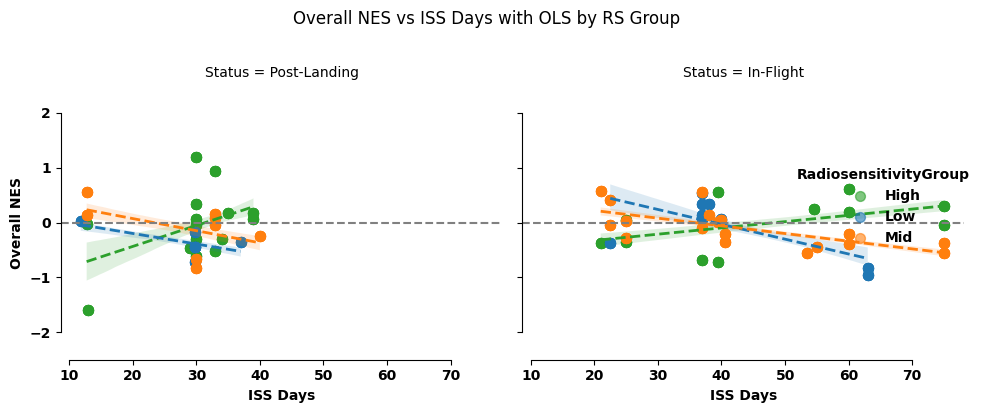

In [ ]:
plot_df = df[df.Status.isin(['In-Flight','Post-Landing'])]

g = sns.lmplot(
    data=plot_df,
    x='ISS_Days', y='Overall_NES',
    hue='RadiosensitivityGroup',
    col='Status',
    palette={'Low':'tab:blue','Mid':'tab:orange','High':'tab:green'},
    scatter_kws={'alpha':0.6, 's':50},
    line_kws={'linewidth':2, 'linestyle':'--'},
    height=4, aspect=1
)
# baseline line and formatting
for ax in g.axes.flatten():
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_ylim(-2.5, 2.5)
    ax.set_ylabel('Overall NES')
    ax.set_xlabel('ISS Days')
g.fig.suptitle('Overall NES vs ISS Days with OLS by RS Group', y=1.02)
sns.despine(trim=True)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.tight_layout()
plt.show()
# Very similar trends for both the status across RS Groups

**Polynomial Curve Fits** of **Biological Pathways** for **In-Flight vs Post-Flight Comparison**

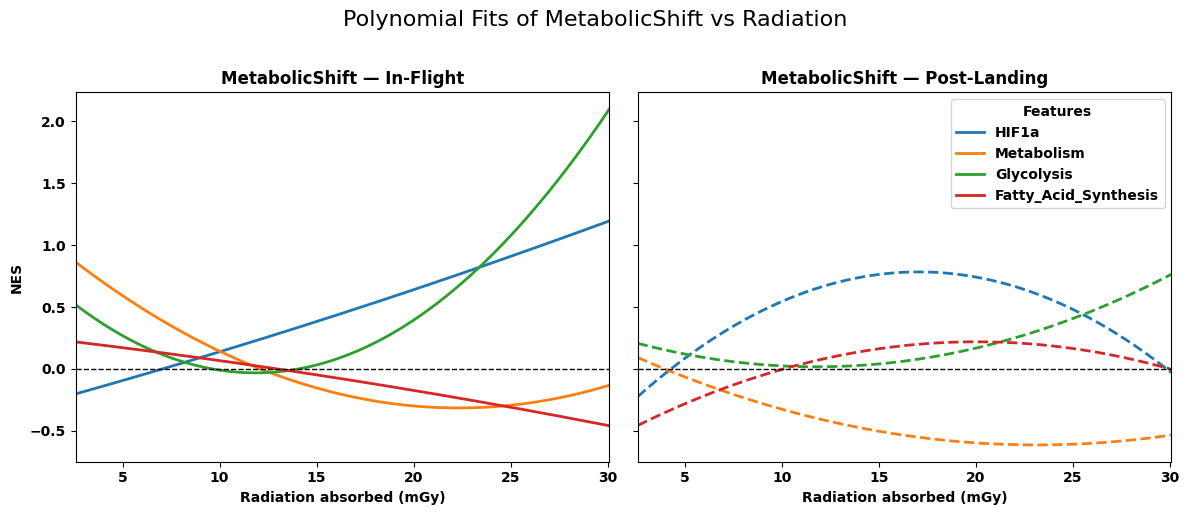

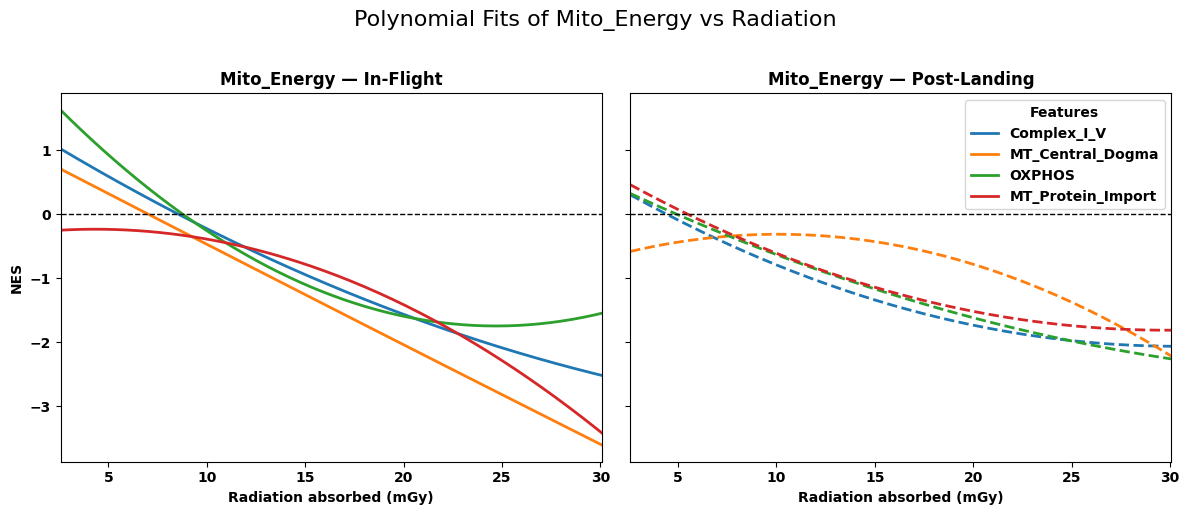

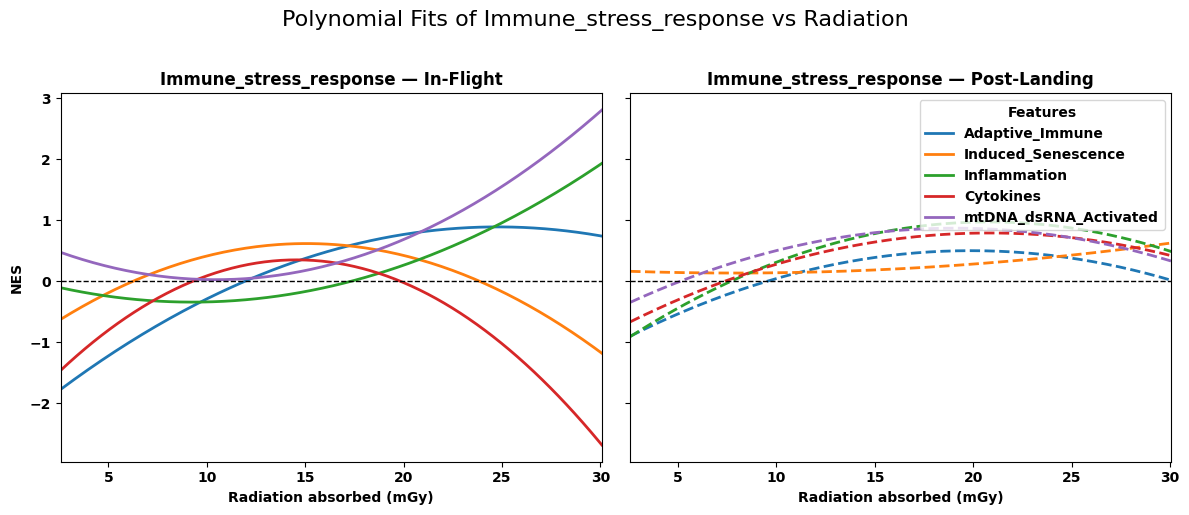

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

# ── 0) Load your dataframes ───────────────────────────────────────────────────
df = pd.read_excel('All_strain.xlsx')        # full DF
di = df[df['Return_Days'] < 1]            # in-flight only
dp = df[df['Return_Days'] > 0]         # post-landing only

# ── 1) If you already have a list of “top correlated” features, inject here ──
sig_features = [
    'HIF1a', 'Metabolism', 'Glycolysis', 'Complex_I_V', 'MT_Central_Dogma', 'OXPHOS', 'MT_Protein_Import',
    'Adaptive_Immune', 'Induced_Senescence', 'mTor', 'Fatty_Acid_Synthesis', 'HIF1a_mTOR',
    'Inflammation', 'Cytokines', 'mtDNA_dsRNA_Activated'
]

# ── 2) Define your three pathway buckets ──────────────────────────────────────
sets = {
    'Mito_Energy':            df.columns[9:21].tolist(),
    'MetabolicShift':         df.columns[22:38].tolist(),
    'Immune_stress_response': df.columns[38:].tolist(),
}

# ── 3) Build a reverse‐lookup so we know which sig_feature lives in which set ─
feature_to_pathway = {}
for pathway, cols in sets.items():
    for c in cols:
        feature_to_pathway[c] = pathway

# Filter our sig_features into per-pathway lists
sig_by_pathway = {}
for feat in sig_features:
    path = feature_to_pathway.get(feat)
    if not path:
        continue
    sig_by_pathway.setdefault(path, []).append(feat)

# ── 4) For each pathway, 2-panel subplot of poly-fits (In-Flight vs Post-Landing) ─
# find the global radiation range:
x_all = df['mGy_Absorbed'].dropna().astype(float)
x_min, x_max = x_all.min(), x_all.max()
x_global = np.linspace(x_min, x_max, 200)

for pathway, feats in sig_by_pathway.items():
    if not feats: continue

    fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)
    for ax, (subdf, status) in zip(
            axes, [(di, 'In-Flight'), (dp, 'Post-Landing')]
        ):

        # Plot each feature
        for feat in feats:
            y = subdf[feat].astype(float)
            mask = (~subdf['mGy_Absorbed'].isna()) & (~y.isna())
            x = subdf.loc[mask, 'mGy_Absorbed'].astype(float)
            y = y[mask]
            if len(x) < 3:
                continue

            coeffs = np.polyfit(x, y, 2)
            poly = np.poly1d(coeffs)

            # always use the global x vector
            linestyle = '-' if status=='In-Flight' else '--'
            ax.plot(x_global, poly(x_global),
                    color='C{}'.format(feats.index(feat)),
                    linestyle=linestyle,
                    linewidth=2,
                    label=feat if status=='In-Flight' else None
            )

        ax.axhline(0, color='black', ls='--', lw=1)
        ax.set_xlim(x_min, x_max)
        ax.set_title(f"{pathway} — {status}", fontweight='bold')
        ax.set_xlabel("Radiation absorbed (mGy)")
        if ax is axes[0]:
            ax.set_ylabel("NES")

    # build a single legend on the rightmost panel:
    handles, labels = axes[0].get_legend_handles_labels()
    axes[1].legend(handles, labels, title="Features", loc='upper right')

    fig.suptitle(f"Polynomial Fits of {pathway} vs Radiation", fontsize=16, y=1.02)
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.tight_layout()
    plt.show()
    # plt.savefig(f"figures/polyfits/{pathway}_polyfits.svg",
    #             format='svg', dpi=600, transparent=False)
    # plt.close(fig)
